# US Airline Twitter Sentiment Analysis

   Airplane travel is a huge business in the US.  People are always talking about their air travel stories to each other being good or bad.  With twitter people can and will tag the airline in their response to their travel.  

   Since Air travel is a service industry Airlines will want to know how they can improve or what they need to do better from their customers.  From twitter data the airlines can see what features are causing positive or negative tweets.  And from the data decide what to do as a company.

   The data was collected from Twitter in February 2015.  The contributors were asked to first classify positive, negative, or neutral tweets.  The data is on kaggle at https://www.kaggle.com/crowdflower/twitter-airline-sentiment.

## Import Data

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('../data/Tweets.csv')

## Clean Text

In [39]:
import nltk
from nltk.corpus import stopwords

In [40]:
def process_tweets(tweet):
    # convert text to lower-case
    tweet = tweet.lower()
    # remove URLs
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 
                   '', tweet)
    # remove usernames
    tweet = re.sub('@[^\s]+', '', tweet)
    # remove the # in #hashtag
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet) 
    # remove punctuation
    tweet = re.sub('[!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]', '', 
                   tweet)
    # remove stopwords
    tweet = ' '.join(word for word in tweet.split() 
                     if word not in stopwords.words('english')) 
            
    return tweet

In [41]:
df['tweet_clean'] = df['text'].apply(process_tweets)

A tweet needs to be cleaned to help improve the learning efficiency of machine learning
models. Tweets contain punctuation, stopwords, and combination of lower and uppercase words,
which affect the model’s learning capability. The following are the steps used in cleaning the tweets:
1. Convert text to lower-case: Converting tweets to lowercace because text analysis is case
sensitive. This means that “Good” and “good” are considered two different words by the
model.
2. Remove URLs: Remove all possible URL links since we are not going to dive deeper into the
links
3. Remove usernames: Remove all possible usernames since we are not going to dive deeper
into the usernames
4. Remove punctuation: Punctuation is removed from data because it does not contribute to
text analysis. It impairs the model’s ability to differentiate between punctuation and other
characters.
5. Remove stopwords: Stopwords have no analytic value in text analysis. They need to be
removed to reduce complexity of the model.

## Word Clouds

In [42]:
from wordcloud import WordCloud

In [43]:
def wordcloud_graph(sentiment='negative'):
    text = " ".join(tweet for tweet in df['tweet_clean'][df['airline_sentiment'] == sentiment])
    # Generate a word cloud image
    wordcloud = WordCloud(stopwords=stopwords.words('english'), 
                          background_color="white").generate(text)

    # Display the generated image:
    # the matplotlib way:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

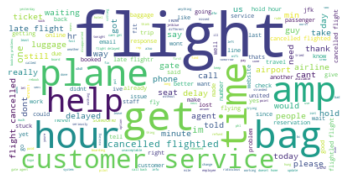

In [44]:
wordcloud_graph('negative')

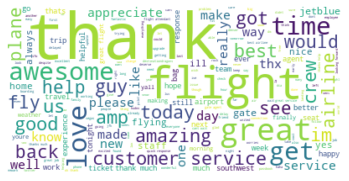

In [45]:
wordcloud_graph('positive')

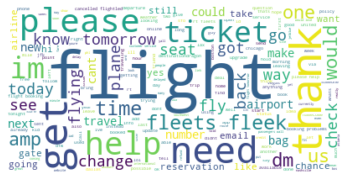

In [46]:
wordcloud_graph('neutral')

The word balloons above show which words show up the most in each type of sentiment.
The word ‘flight’ is an often used word in all three sentiments. Negative sentiments contain:
customer service, help, plane, and bag. On the positive sentiment word balloon we see ‘thank’ as
the most prominent word. Neutral sentiments have please, need, and get as prominent words.
These word balloon graphs show a snapshot of prominent words that will likely be used in the
models.

## Model Selection

Now that the data is cleaned and organized, a predictive model may be built with the sklearn
algorithms. The model will be trying to predict the airline_sentiment using text from the tweets.
Classifier machine learning algorithms will be used.

In [47]:
from sklearn.model_selection import train_test_split

In [48]:
# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(df['tweet_clean'], 
                                                    df['airline_sentiment'], 
                                                    test_size=0.33, 
                                                    shuffle=True, 
                                                    random_state = 42)

The text data was split into training and testing sets

### Models

In [49]:
from sklearn.model_selection import KFold

# use it because it is fast with count vectorizer
from sklearn.naive_bayes import MultinomialNB 
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MaxAbsScaler

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import time
from scipy import stats

from sklearn.pipeline import Pipeline
import pickle

In [50]:
# have the model be split into 3 folds
kfold = KFold(n_splits=3, shuffle=True, random_state=42)

# set f1 variable as constant
f1='f1_macro'

Kfold was used to split the training set into training and validation sets.

The scoring parameter the models will use is F1. F1 score conveys a balance between
precision (number of positive predictions divided by the total number of positive class values
predicted) and recall (number of positive predictions divided by the number of positive class values
in the test data). A higher F1 score means the model is better at prediction.

In [51]:
# create multinomialNB clf and hyperparameters
clf_mnb = MultinomialNB()
mnb_hyperparameters = {'vect__ngram_range': [(1, 1), (1, 2)],
                       'clf__alpha': [0.001, 0.01, 0.1, 10, 20, 30, 40, 
                                      50, 60, 70, 80, 90, 100]}

# create SVC clf and hyperparameters
clf_svc = SVC()
svc_hyperparameters = {'vect__ngram_range': [(1, 1), (1, 2)],
                       'clf__C': stats.expon(scale=100), 
                       'clf__gamma': stats.expon(scale=.1), 
                       'clf__kernel': ['rbf'], 
                       'clf__class_weight': ['balanced', None]}

# create RandomForestClassifier clf and hyperparameters
clf_rfc = RandomForestClassifier()
rfc_hyperparameters = {'vect__ngram_range': [(1, 1), (1, 2)],
                       'clf__n_estimators': stats.randint(10,300), 
                       'clf__criterion': ['gini', 'entropy'], 
                       'clf__min_samples_split': stats.randint(2,9), 
                       'clf__bootstrap': [True, False],
                       'clf__class_weight': [None, 'balanced', 
                                             'balanced_subsample']
                      }

# Create Vectorizers
cv = CountVectorizer()
tf = TfidfVectorizer()

Classification algorithms will be used to predict the twitter sentiment.
Three algorithms will be tested. Naive Bayes, SVC, and Random Forest. Each of these algorithms
will also be tuned with cross validation to find the best algorithm parameters for the model.

The text data will be put into vectors to build a vocabulary for analysis. The two vectorizers
are CountVectorizer and TfidfVectorizer. CountVectorizer provides a simple way to both tokenize a
text and build a vocabulary of known words. It also encodes the text using the vocabulary it built.
TfidfVectorizer calculates word frequencies. It will tokenize, learn the vocabulary, inverse text
frequency weightings and encode new text.

### Cross Validation

In [52]:
# function that gets the best scores from the training and validatin sets of 
# Cross Validation
def clf_scores(clf):
    training_score = clf.cv_results_['mean_train_score'][clf.best_index_]
    training_std = clf.cv_results_['std_train_score'][clf.best_index_]

    validation_score = clf.best_score_
    test_std = clf.cv_results_['std_test_score'][clf.best_index_]
    
    train = str(round(training_score, 3)) + ' (' + str(round(training_std, 3)) + ')' 
    val = str(round(validation_score, 3)) + ' (' + str(round(test_std, 3)) + ')'

    score_list = {'train-score': train, 
                  'validation-score': val}
    
    return score_list

Each model during the
Randomized Search and Grid Search Cross Validation will give a F1 score and a mean and standard
deviation will be taken of each F1 score of all models.

In [53]:
# Save the model
def clf_save(clf, filename):
    file = '../models/' + filename + '.sav'
    pickle.dump(clf, open(file, 'wb'))

In [54]:
# Runs grid search on pipeline and data set given
# returns scores in dictionary
def train_and_score_model_gridcv(name, X_train, y_train, pipeline, model_info, 
                                 kfold, score='f1_macro'):
    t0 = time.time()

    searchCV = GridSearchCV(estimator=pipeline, 
                            param_grid=model_info, 
                            cv=kfold,
                            scoring=score,
                            n_jobs=-1, 
                            return_train_score=True)

    searchCV.fit(X_train, y_train)
    
    # Gets scores of clf
    score = clf_scores(searchCV)
    
    # save model
    clf_save(searchCV, name)
    
    t1 = time.time()
    timeit = round((t1-t0), 2)
    
    print(name, str(timeit) + ' sec')
    
    return score  

In [55]:
# Runs random search on pipeline and data set given
# returns scores in dictionary
def train_and_score_model_rscv(name, X_train, y_train, pipeline, model_info, 
                               kfold, niter=1000, score='f1_macro'):
    t0 = time.time()
    
    searchCV = RandomizedSearchCV(estimator=pipeline, 
                                  param_distributions=model_info, 
                                  cv=kfold,
                                  n_iter=niter,
                                  scoring=score,
                                  random_state=42, 
                                  n_jobs=-1, 
                                  return_train_score=True)
    
    searchCV.fit(X_train, y_train)
    
    # Gets scores of clf
    score = clf_scores(searchCV)
    
    # save model
    clf_save(searchCV, name)
    
    t1 = time.time()
    timeit = round((t1-t0) / 60 / 60, 3)
    
    print(name, str(timeit) + ' hrs')

    return score

In [56]:
# Create dicts with vectors
vector_list = {'CountVectorizer': cv,
               'TfidfVectorizer': tf}

# Create dict with models and parameters
models_list = {'MultinomialNB': (clf_mnb, mnb_hyperparameters),
               'SVC': (clf_svc, svc_hyperparameters),
               'RandomForestClassifer': (clf_rfc, rfc_hyperparameters)}

# Dict to store model scores
model_cvs = {}

In [57]:
# Cycle through every Vectorizer
for vector_name, vector_info in vector_list.items():
    # Cycle through models for cross validation
    for model_name, model_info in models_list.items():
        # create pipeline with vector, scaler and clf
        clf_pipeline = Pipeline([('vect', vector_info),
                                 ('scaler', MaxAbsScaler()), 
                                 ('clf', model_info[0])])
        # create string with vector and model name
        name = vector_name + model_name
        # if model is MultinomialNB use gridsearchcv
        if model_name == 'MultinomialNB':
            model_cvs[name] = train_and_score_model_gridcv(name,
                                                           X_train, 
                                                           y_train,  
                                                           clf_pipeline, 
                                                           model_info[1], 
                                                           kfold, 
                                                           f1)
        else: # else use randomsearchcv
            model_cvs[name] = train_and_score_model_rscv(name,
                                                         X_train, 
                                                         y_train, 
                                                         clf_pipeline, 
                                                         model_info[1], 
                                                         kfold, 
                                                         1000, 
                                                         f1)

CountVectorizerMultinomialNB 18.55 sec
CountVectorizerSVC 4.332 hrs
CountVectorizerRandomForestClassifer 6.587 hrs
TfidfVectorizerMultinomialNB 15.41 sec
TfidfVectorizerSVC 4.647 hrs
TfidfVectorizerRandomForestClassifer 6.365 hrs


After the vocabulary vectorizers are built the data will be scaled using MaxAbsScaler.
MaxAbsScaler scales and translates each feature individually such that the maximal absolute value
of each feature is the training set will be 1.0. It does not shift/center the data, and thus does not
destroy any sparisity. Scaling helps to not let features with larger units have undue influence on the
classifier as would be the case if the classifier uses some sort of distance measurement as a
similarity metric.

In [58]:
# create df from model_cvs scores dict
df_scores = pd.DataFrame.from_dict(model_cvs).transpose()
df_scores

,train-score,validation-score
CountVectorizerMultinomialNB,0.969 (0.002),0.634 (0.009)
CountVectorizerSVC,0.968 (0.001),0.707 (0.01)
CountVectorizerRandomForestClassifer,0.991 (0.001),0.701 (0.012)
TfidfVectorizerMultinomialNB,0.985 (0.001),0.639 (0.009)
TfidfVectorizerSVC,0.88 (0.001),0.695 (0.005)
TfidfVectorizerRandomForestClassifer,0.99 (0.001),0.698 (0.011)


After running all the different models with Randomized Search
and Grid Search cross validation results were obtained. The models with the best mean F1 score
and mean standard deviation were used to predict the test set.

## Model Evaluation

In [59]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [63]:
# Create dict that holds metrics
metric_dict = {}
metric_dict['accuracy'] = []
metric_dict['precision'] = []
metric_dict['recall'] = []
metric_dict['f1'] = []

file_names = df_scores.index

# Cycle through models predicting on test data and giving metrics
for f in file_names:
    # load models
    file = '../models/' + f + '.sav'
    loaded_model = pickle.load(open(file, 'rb'))
    # predict test set
    prediction = loaded_model.predict(X_test)
    
    # accuracy: (tp + tn) / (p + n)
    accuracy = round(accuracy_score(y_test, prediction), 3)
    metric_dict['accuracy'].append(accuracy)
    # precision tp / (tp + fp)
    precision = round(precision_score(y_test, prediction, average='macro'), 3)
    metric_dict['precision'].append(precision)
    # recall: tp / (tp + fn)
    recall = round(recall_score(y_test, prediction, average='macro'), 3)
    metric_dict['recall'].append(recall)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = round(f1_score(y_test, prediction, average='macro'), 3)
    metric_dict['f1'].append(f1)

In [64]:
# add metrics to df_scores
for k in metric_dict.keys():
    df_scores[k] = metric_dict[k]
    
df_scores

,train-score,validation-score,accuracy,precision,recall,f1
CountVectorizerMultinomialNB,0.969 (0.002),0.634 (0.009),0.739,0.688,0.617,0.641
CountVectorizerSVC,0.968 (0.001),0.707 (0.01),0.774,0.731,0.699,0.713
CountVectorizerRandomForestClassifer,0.991 (0.001),0.701 (0.012),0.755,0.690,0.688,0.689
TfidfVectorizerMultinomialNB,0.985 (0.001),0.639 (0.009),0.735,0.669,0.624,0.640
TfidfVectorizerSVC,0.88 (0.001),0.695 (0.005),0.749,0.696,0.713,0.703
TfidfVectorizerRandomForestClassifer,0.99 (0.001),0.698 (0.011),0.761,0.707,0.694,0.700


The above table shows the F1
scores for the training and validation sets of each model followed by the metrics accuracy, precision,
recall, and F1 score of the test sets.

From the table above we see that using the CountVectorizer and SVC algorithm had the
highest scores in the majority of categories. It had an accuracy of 77.4% and an F1 score of 0.713.
These are good scores even with the data being unbalanced in favor of negative sentiment.